In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json

## Data

### Setup

In [3]:
PATH = Path('data/carvana')
list(PATH.iterdir())

[PosixPath('data/carvana/train_masks'),
 PosixPath('data/carvana/test.zip'),
 PosixPath('data/carvana/train-512'),
 PosixPath('data/carvana/train_masks.csv'),
 PosixPath('data/carvana/train_masks-1024'),
 PosixPath('data/carvana/train_masks.zip'),
 PosixPath('data/carvana/train_hq'),
 PosixPath('data/carvana/train_masks.csv.zip'),
 PosixPath('data/carvana/train_masks-512'),
 PosixPath('data/carvana/train'),
 PosixPath('data/carvana/train_masks-128'),
 PosixPath('data/carvana/test_hq'),
 PosixPath('data/carvana/metadata.csv.zip'),
 PosixPath('data/carvana/tmp'),
 PosixPath('data/carvana/sample_submission.csv.zip'),
 PosixPath('data/carvana/test_hq.zip'),
 PosixPath('data/carvana/metadata.csv'),
 PosixPath('data/carvana/train-128'),
 PosixPath('data/carvana/train_hq.zip'),
 PosixPath('data/carvana/sample_submission.csv'),
 PosixPath('data/carvana/29bb3ece3180_11.jpg'),
 PosixPath('data/carvana/models'),
 PosixPath('data/carvana/train_masks_png'),
 PosixPath('data/carvana/train.zip'),
 Po

In [4]:
MASKS_FN = 'train_masks.csv'
META_FN = 'metadata.csv'
TRAIN_DN = 'train'
MASKS_DN = 'train_masks'

In [5]:
masks_csv = pd.read_csv(PATH/MASKS_FN)
masks_csv.head()

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


In [6]:
meta_csv = pd.read_csv(PATH/META_FN)
meta_csv.head()

,id,year,make,model,trim1,trim2
0,0004d4463b50,2014.0,Acura,TL,TL,w/SE
1,00087a6bd4dc,2014.0,Acura,RLX,RLX,w/Tech
2,000aa097d423,2012.0,Mazda,MAZDA6,MAZDA6,i Sport
3,000f19f6e7d4,2016.0,Chevrolet,Camaro,Camaro,SS
4,00144e887ae9,2015.0,Acura,TLX,TLX,SH-AWD V6 w/Advance Pkg


In [7]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [8]:
CAR_ID = '00087a6bd4dc'

In [9]:
list((PATH/TRAIN_DN).iterdir())[:5]

[PosixPath('data/carvana/train/5bc30efeb7bf_11.jpg'),
 PosixPath('data/carvana/train/e114fcbb9723_13.jpg'),
 PosixPath('data/carvana/train/e2230d0ceb02_02.jpg'),
 PosixPath('data/carvana/train/695f39dfac16_14.jpg'),
 PosixPath('data/carvana/train/3d7a1030deeb_02.jpg')]

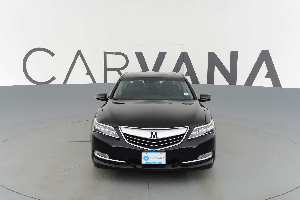

In [10]:
Image.open(PATH/TRAIN_DN/f'{CAR_ID}_01.jpg').resize((300,200))

In [11]:
list((PATH/MASKS_DN).iterdir())[:5]

[PosixPath('data/carvana/train_masks/9274d0b3caa8_08_mask.gif'),
 PosixPath('data/carvana/train_masks/e114fcbb9723_08_mask.gif'),
 PosixPath('data/carvana/train_masks/5bcde75955bb_08_mask.gif'),
 PosixPath('data/carvana/train_masks/3cb21125f126_08_mask.gif'),
 PosixPath('data/carvana/train_masks/08a646be6b30_07_mask.gif')]

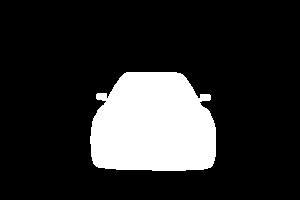

In [12]:
Image.open(PATH/MASKS_DN/f'{CAR_ID}_01_mask.gif').resize((300,200))

In [13]:
ims = [open_image(PATH/TRAIN_DN/f'{CAR_ID}_{i+1:02d}.jpg') for i in range(16)]

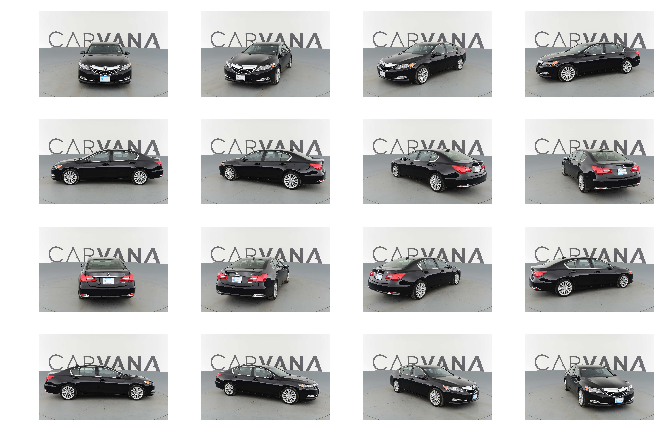

In [14]:
fig, axes = plt.subplots(4, 4, figsize=(9, 6))
for i,ax in enumerate(axes.flat): show_img(ims[i], ax=ax)
plt.tight_layout(pad=0.1)

### Resize and convert

In [ ]:
(PATH/'train_masks_png').mkdir(exist_ok=True)

In [ ]:
def convert_img(fn):
    fn = fn.name
    Image.open(PATH/'train_masks'/fn).save(PATH/'train_masks_png'/f'{fn[:-4]}.png')

In [ ]:
files = list((PATH/'train_masks').iterdir())
with ThreadPoolExecutor(8) as e: e.map(convert_img, files)

In [ ]:
def resize_mask(m):
    fn, sz = m
    Image.open(fn).resize((sz,sz)).save((fn.parent.parent)/f'train_masks-{sz}'/fn.name)

def get_masks(sz):
    return list((m, sz) for m in (PATH/'train_masks_png').iterdir())

def resize_img(i):
    fn, sz = i
    Image.open(fn).resize((sz,sz)).save((fn.parent.parent)/f'train-{sz}'/fn.name)

def get_images(sz):
    return list((i, sz) for i in (PATH/'train').iterdir())
    
for s in [128, 512, 1024]:
    masks = get_masks(s)
    (PATH/f'train_masks-{s}').mkdir(exist_ok=True)
    with ThreadPoolExecutor(8) as e: e.map(resize_mask, masks)
        
    images = get_images(s)
    (PATH/f'train-{s}').mkdir(exist_ok=True)
    with ThreadPoolExecutor(8) as e: e.map(resize_img, images)

## Dataset

In [15]:
TRAIN_DN = 'train-128'
MASKS_DN = 'train_masks-128'
sz = 128
bs = 64

In [16]:
ims = [open_image(PATH/TRAIN_DN/f'{CAR_ID}_{i+1:02d}.jpg') for i in range(16)]
im_masks = [open_image(PATH/MASKS_DN/f'{CAR_ID}_{i+1:02d}_mask.png') for i in range(16)]

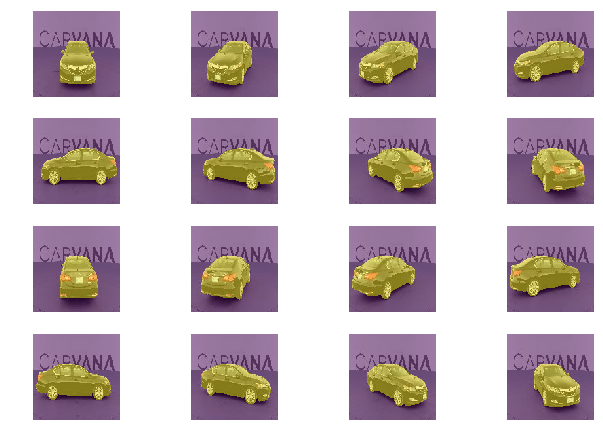

In [17]:
fig, axes = plt.subplots(4, 4, figsize=(9, 6))
for i,ax in enumerate(axes.flat):
    ax = show_img(ims[i], ax=ax)
    show_img(im_masks[i][...,0], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

In [18]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [19]:
x_names = np.array([Path(TRAIN_DN)/o for o in masks_csv['img']])
y_names = np.array([Path(MASKS_DN)/f'{o[:-4]}_mask.png' for o in masks_csv['img']])

In [20]:
len(x_names)//16//5*16

1008

In [21]:
val_idxs = list(range(1008))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
len(val_x),len(trn_x)

(1008, 4080)

In [22]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.PIXEL),
            RandomFlip(tfm_y=TfmType.PIXEL),
            RandomLighting(0.05, 0.05)]
# aug_tfms = []

In [23]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)

In [24]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)
y = denorm(y)

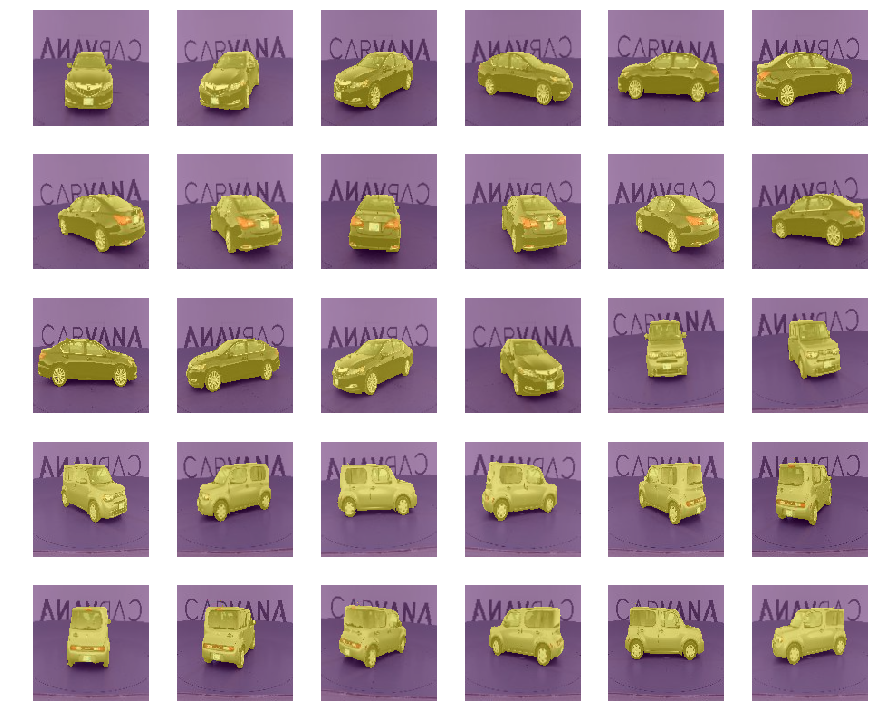

In [25]:
fig, axes = plt.subplots(5, 6, figsize=(12, 10))
for i,ax in enumerate(axes.flat):
    ax=show_img(x[i], ax=ax)
    show_img(y[i][...,0], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

## Model

In [26]:
class Empty(nn.Module): 
    def forward(self,x): return x

models = ConvnetBuilder(vgg16, 0, 0, 0, custom_head=Empty())
learn = ConvLearner(md, models)
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('trainable', False),
                           ('nb_params', 1792)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 128, 128]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 128, 128]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 64, 128, 128]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('trainable', False),
                           ('nb_params', 36928)])),
             ('BatchNorm2d-5',

In [27]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [28]:
simple_up = nn.Sequential(
    nn.ReLU(),
    StdUpsample(512,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    nn.ConvTranspose2d(256, 1, 2, stride=2),
)

In [29]:
def mask_loss(pred,targ):
    return F.binary_cross_entropy_with_logits(pred[:,0],targ[:,0])

def mask_acc(pred,targ): return accuracy_multi(pred[:,0], targ[:,0], 0.5)

def dice(pred, targ):
    m1 = (pred[:,0]>0).float()
    m2 = targ[:,0]
    return 2. * (m1*m2).sum() / (m1+m2).sum()

In [30]:
models = ConvnetBuilder(vgg16, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=mask_loss
learn.metrics=[mask_acc, dice]

In [ ]:
learn.lr_find()
learn.sched.plot()

In [ ]:
lr=4e-2

In [ ]:
learn.fit(lr,1,cycle_len=5,use_clr=(10,5))

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.save('tmp')

In [ ]:
learn.load('tmp')

In [ ]:
py,ay = learn.predict_with_targs()

In [ ]:
show_img(np.rollaxis(ay[0], 0, 3))

In [ ]:
show_img(py[0][0]>0);

In [ ]:
learn.unfreeze()

In [ ]:
learn.bn_freeze(True)

In [ ]:
lrs = np.array([lr/100,lr/10,lr])/4

In [ ]:
learn.fit(lrs,1,cycle_len=40,use_clr=(20,10))

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.save('0')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [ ]:
ax = show_img(denorm(x)[0])
show_img(py[0][0]>0, ax=ax, alpha=0.5);

In [ ]:
ax = show_img(denorm(x)[0])
show_img(denorm(y)[0,...,-1], ax=ax, alpha=0.5);

## 512x512

In [31]:
TRAIN_DN = 'train-512'
MASKS_DN = 'train_masks-512'
sz = 512
bs = 8

In [32]:
x_names = np.array([Path(TRAIN_DN)/o for o in masks_csv['img']])
y_names = np.array([Path(MASKS_DN)/f'{o[:-4]}_mask.png' for o in masks_csv['img']])

In [33]:
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
len(val_x),len(trn_x)

(1008, 4080)

In [34]:
tfms = tfms_from_model(vgg16, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=4, classes=None)

In [35]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)
y = denorm(y)

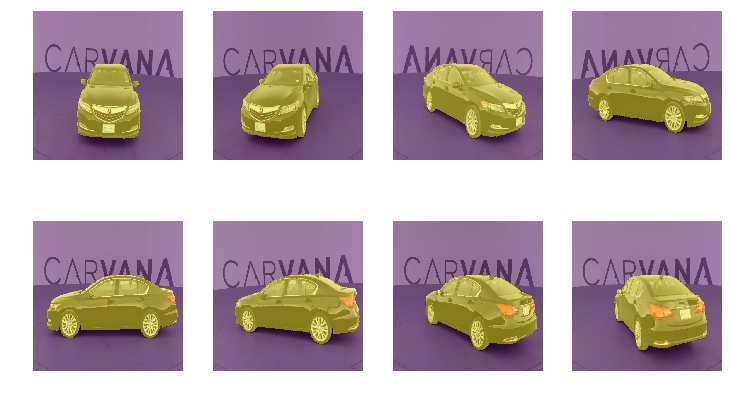

In [36]:
fig, axes = plt.subplots(2, 4, figsize=(10, 6))
for i,ax in enumerate(axes.flat):
    ax=show_img(x[i], ax=ax)
    show_img(y[i][...,0], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

In [37]:
simple_up = nn.Sequential(
    nn.ReLU(),
    StdUpsample(512,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    nn.ConvTranspose2d(256, 1, 2, stride=2),
)

In [38]:
models = ConvnetBuilder(vgg16, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=mask_loss
learn.metrics=[mask_acc, dice]

In [ ]:
learn.load('0')

In [ ]:
learn.lr_find()
learn.sched.plot()

In [39]:
lr=4e-2

In [ ]:
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

In [ ]:
learn.save('tmp')

In [40]:
learn.load('tmp')

In [41]:
learn.unfreeze()
learn.bn_freeze(True)

In [42]:
lrs = np.array([lr/100,lr/10,lr])/4

In [43]:
learn.fit(lrs,1,cycle_len=8,use_clr=(20,8))

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

epoch      trn_loss   val_loss   mask_acc   dice              
    0      0.011247   0.012214   0.995579   0.988617  
    1      0.428442   0.278586   0.890162   0.750164           
    2      0.05369    0.054966   0.979472   0.946682          
    3      0.040128   0.038943   0.984776   0.962313          
    4      0.032097   0.033428   0.986138   0.96752           
    5      0.028584   0.029117   0.988765   0.972264          
    6      0.026588   0.026795   0.988845   0.974401          
    7      0.025195   0.026153   0.988881   0.974976          



[0.026153227, 0.98888096733698772, 0.97497557366491683]

In [44]:
learn.save('512')

In [45]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

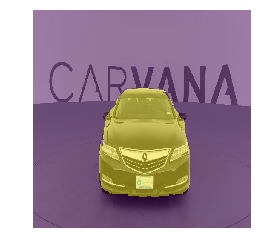

In [46]:
ax = show_img(denorm(x)[0])
show_img(py[0][0]>0, ax=ax, alpha=0.5);

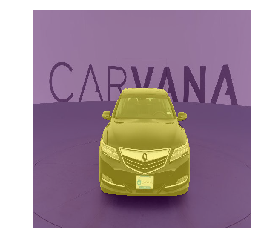

In [47]:
ax = show_img(denorm(x)[0])
show_img(denorm(y)[0,...,-1], ax=ax, alpha=0.5);

## 1024x1024

In [32]:
TRAIN_DN = 'train-1024'
MASKS_DN = 'train_masks-1024'
sz = 1024
bs = 2

In [33]:
ims = [open_image(PATH/TRAIN_DN/f'{CAR_ID}_{i+1:02d}.jpg') for i in range(16)]
im_masks = [open_image(PATH/MASKS_DN/f'{CAR_ID}_{i+1:02d}_mask.png') for i in range(16)]

In [34]:
x_names = np.array([Path(TRAIN_DN)/o for o in masks_csv['img']])
y_names = np.array([Path(MASKS_DN)/f'{o[:-4]}_mask.png' for o in masks_csv['img']])

In [35]:
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
len(val_x),len(trn_x)

(1008, 4080)

In [49]:
tfms = tfms_from_model(vgg16, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=2, classes=None)

In [37]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)
y = denorm(y)

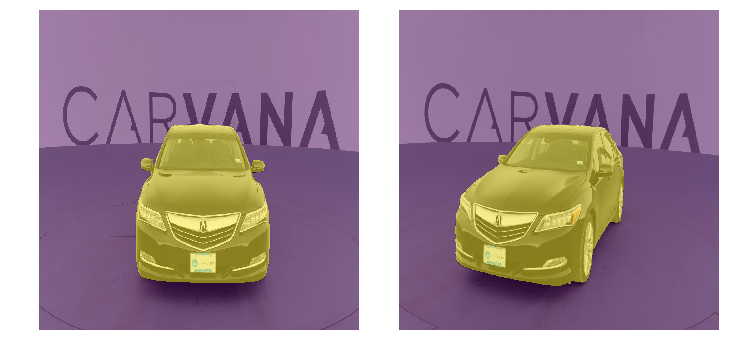

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
for i,ax in enumerate(axes.flat):
    ax=show_img(x[i], ax=ax)
    show_img(y[i][...,0], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

In [45]:
simple_up = nn.Sequential(
    nn.ReLU(),
    StdUpsample(512,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    nn.ConvTranspose2d(256, 1, 2, stride=2),
)

In [46]:
models = ConvnetBuilder(vgg16, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=mask_loss
learn.metrics=[mask_acc, dice]

In [98]:
learn.load('512')

In [44]:
!pip install memory_profiler

  Running setup.py bdist_wheel for memory-profiler ... done
  Stored in directory: /home/caleb/.cache/pip/wheels/55/a6/a8/1f55bf957cae1c3608eff4f5d8746a64688df3658f74b67dac
Successfully built memory-profiler
You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [41]:
%load_ext memory_profiler

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 73%|███████▎  | 1484/2040 [06:26<02:24,  3.83it/s, loss=0.343] 

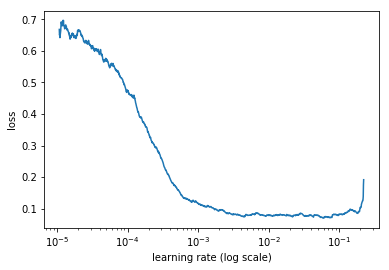

In [60]:
learn.lr_find()
learn.sched.plot()

In [47]:
lr=4e-2

In [ ]:
%memit learn.fit(lr,1,cycle_len=2,use_clr=(20,4))

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

  2%|▏         | 32/2040 [00:08<09:14,  3.62it/s, loss=0.0414]

Exception in thread Thread-7:
Traceback (most recent call last):
  File "/home/caleb/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/caleb/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/caleb/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



 19%|█▉        | 394/2040 [01:44<07:16,  3.77it/s, loss=0.039] 

In [ ]:
learn.save('tmp')

In [ ]:
learn.load('tmp')

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
lrs = np.array([lr/100,lr/10,lr])/8

In [ ]:
learn.fit(lrs,1,cycle_len=4,use_clr=(20,8))

In [ ]:
learn.fit(lrs,1,cycle_len=40,use_clr=(20,10))

In [ ]:
learn.save('1024')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [ ]:
ax = show_img(denorm(x)[0])
show_img(py[0][0]>0, ax=ax, alpha=0.5);

In [ ]:
ax = show_img(denorm(x)[0])
show_img(y[0,...,-1], ax=ax, alpha=0.5);

In [ ]:
show_img(py[0][0]>0);

In [ ]:
show_img(y[0,...,-1]);

## Fin

In [ ]:
x,y = next(iter(md.val_dl))

In [ ]:
py = to_np(learn.model(V(x)))

In [ ]:
ax = show_img(denorm(x)[0])
show_img(py[0][0]>0, ax=ax, alpha=0.5);

In [ ]:
ax = show_img(denorm(x)[0])
